## Store Sales - Time Series Forecasting

### **Descriptions**

**train.csv:**
* store_nbr =  identifies the store at which the products are sold.
* family =  identifies the type of product sold.
* sales = total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
* onpromotion = the total number of items in a product family that were being promoted at a store at a given date.

**test.csv:**
* Same features as the training data. The target sales for the dates in this files.
* The dates in the test are for the 15 days after the last date in the training data.

**stores.csv**

* Store metadata: city, state, type and cluster.
* Cluster is a grouping of similar stores.

**oil.csv**

* Daily oil price. Include values during both the train and test data timeframes.
* Ecuador is an oil-dependent country and it´s economical health is highly bulnerable to shocks in oil prices.


**Holidays_events.csv**

* Holidays and events, with metadata.
* Transferred column: A transferred day is more like a normal day than a holiday.

**Additional Notes**
* Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this. (Seasonality?)
* A magnitude 7.8 earthquake struck Ecuador on `April 16, 2016`. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Metrics
from sklearn.metrics import mean_squared_error

### 1st Part: **EDA**

In [3]:
# Paths
train_pth = r"C:\Users\willi\OneDrive\Documentos\5. Estudos\Kaggle_Notebooks\Store_Sales\data\train.csv"
test_pth = r"C:\Users\willi\OneDrive\Documentos\5. Estudos\Kaggle_Notebooks\Store_Sales\data\test.csv"
stores_pth = r"C:\Users\willi\OneDrive\Documentos\5. Estudos\Kaggle_Notebooks\Store_Sales\data\stores.csv"
oil_pth = r"C:\Users\willi\OneDrive\Documentos\5. Estudos\Kaggle_Notebooks\Store_Sales\data\oil.csv"
transactions_pth = r"C:\Users\willi\OneDrive\Documentos\5. Estudos\Kaggle_Notebooks\Store_Sales\data\transactions.csv"
holidays_events_pth = r"C:\Users\willi\OneDrive\Documentos\5. Estudos\Kaggle_Notebooks\Store_Sales\data\holidays_events.csv"

<p style="text-align: justify"> When we see to this dataset, we see that columns dates are deconfigured. One option to solve this is to focus the feature values ​​around the day of the date column. Let's see how we can do this.</p>

In [4]:
# Importing Datasets
train = pd.read_csv(train_pth)
test = pd.read_csv(test_pth)
stores = pd.read_csv(stores_pth)
oil = pd.read_csv(oil_pth)
events = pd.read_csv(holidays_events_pth, parse_dates=['date'])
transactions = pd.read_csv(transactions_pth)

### **File:** stores.csv
<p style="text-align: justify">Let's start with stores.csv! We can see that the data of "stores.csv" is only to give us some information about the stores, like location, cluster and others.</p>

In [5]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


### **File:** oil.csv
<p style="text-align: justify">The file about oil consume (oil.csv) is very interesting!! Let's see if we find duplicate data in the date column.</p>

In [6]:
print('The column date has only single values?\n', oil.date.is_unique) # Check if values are unique. OK!!!

The column date has only single values?
 True


### **File:** holidays_events.csv
<p style="text-align: justify">The Events file has a date columns. If we check this column we will see duplicates values.  </p>

In [7]:
print('The column date has only single values?\n', events.date.is_unique) #  The values are not unique.

The column date has only single values?
 False


<p style="text-align: justify">So, we need to find an solution to solve this. Firstly, It's observed that all columns in events.csv are categorical (object). So, this information is very important. It's also noticed that de Column "date" instead of a DateTime object.</p>

In [8]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


<p style="text-align: justify">If we look carefully, It's possible to check which dates are duplicated.</p>

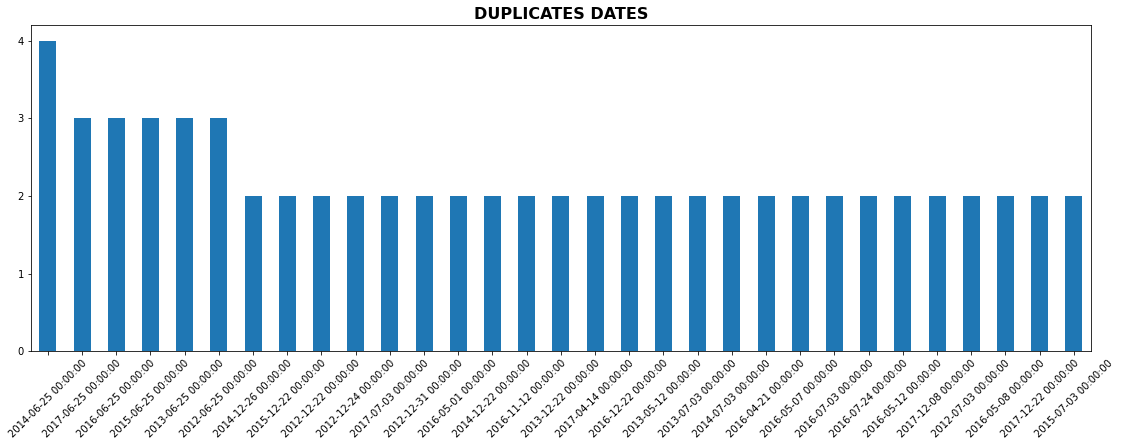

In [9]:
df_event_dupl = pd.DataFrame(events.date.value_counts())
df_event_dupl.rename(columns={'date':'values'})
df_event_dupl[df_event_dupl>=2].dropna().plot(kind='bar', figsize=(19,6), legend=None)
plt.xticks(rotation=45)
plt.yticks(np.arange(0,5))
plt.title("DUPLICATES DATES", fontweight="bold", fontsize=16)
plt.show()

In [10]:
events[events.date=="2014-06-25"] # See!! There are duplicated values.

,date,type,locale,locale_name,description,transferred
110,2014-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
111,2014-06-25,Holiday,Local,Machala,Fundacion de Machala,False
112,2014-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
113,2014-06-25,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Francia,False


<p style="text-align: justify">So, we will deal with this by aggregating values ​​related to the same date.  </p>

In [11]:
event_cat_col = [c for c in events.columns if events[c].dtypes=='O'] # Separating Categoricals Columns
events.set_index('date')
from feature_engine.encoding import OneHotEncoder
ohe = OneHotEncoder(variables=event_cat_col)
events = ohe.fit_transform(events)
col_event = events.iloc[:,1:].columns.to_list()
events = events.groupby('date')[col_event].sum()

C:\Users\willi\AppData\Local\Programs\Python\Python39\lib\site-packages\feature_engine\encoding\one_hot.py:276: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[str(feature) + "_" + str(category)] = np.where(


In [12]:
events[events.index=="2014-06-25"] # See!! No more duplicated values.

,transferred,type_Holiday,type_Transfer,type_Additional,type_Bridge,type_Work Day,type_Event,locale_Local,locale_Regional,locale_National,...,description_Terremoto Manabi+28,description_Terremoto Manabi+29,description_Terremoto Manabi+30,description_Traslado Batalla de Pichincha,description_Traslado Fundacion de Guayaquil,description_Traslado Primer Grito de Independencia,description_Puente Dia de Difuntos,description_Recupero Puente Dia de Difuntos,description_Traslado Primer dia del ano,description_Traslado Fundacion de Quito
date,,,,,,,,,,,,,,,,,,,,,
2014-06-25,0,3,0,0,0,0,1,2,1,1,...,0,0,0,0,0,0,0,0,0,0


### **File:** transactions.csv
<p style="text-align: justify">This file contains 3 (three) columns: date, store_nbr (like as the train.csv file) and transaction's column. Let's see if there are duplicates valoes in this date column.</p>

In [13]:
print('The column date has only single values?\n', transactions.date.is_unique) #  The values are not unique.

The column date has only single values?
 False


<p style="text-align: justify">There are a lot of transactions by stores and by date. So we will divide them in TRANSACTIONS - DATE and TRANSACTION - STORE.</p>

In [14]:
transactions_store = transactions.groupby('store_nbr')['transactions'].sum()
transactions_date = transactions.groupby('date')['transactions'].sum()

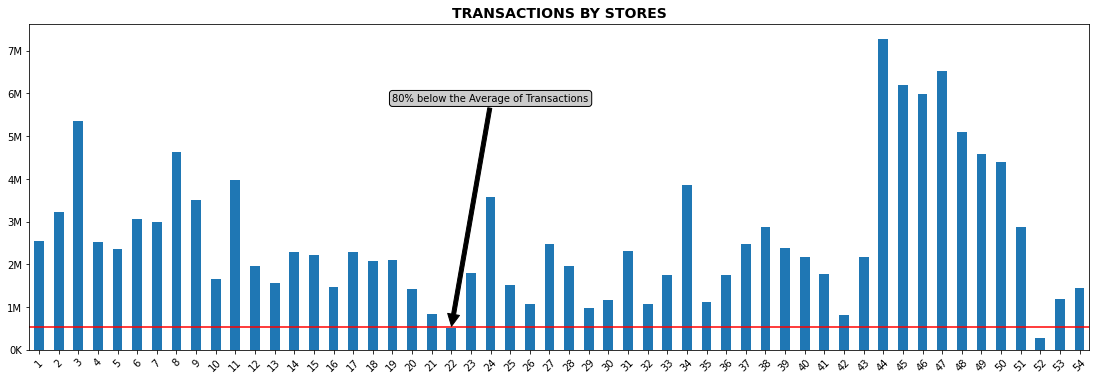

In [15]:
def values(x, pos):
    """The two arguments are the value and tick position"""
    if x >= 1e6:
        s = '{:1.0f}M'.format(x*1e-6)
    else:
        s = '{:1.0f}K'.format(x*1e-3)
    return s
percent = 80
threshold =  transactions.transactions.sum()/len(transactions.store_nbr.unique()) * ((100 - percent)/100)
fig, ax = plt.subplots(figsize= (19,6))
transactions_store.dropna().plot(kind='bar',legend=None)
plt.xticks(rotation=45)
ax.set_title("TRANSACTIONS BY STORES", fontweight="bold", fontsize=14)
ax.set_xlabel(None)
ax.yaxis.set_major_formatter(values)
ax.axhline(y=threshold, color='red')
ax.annotate(f'{ percent:.0f}% below the Average of Transactions', xy=(21, threshold), xytext=(23, 6000000),bbox=dict(boxstyle="round", fc="0.8"), arrowprops=dict(facecolor='black', shrink=0.005),horizontalalignment='center', verticalalignment='top')
plt.show()

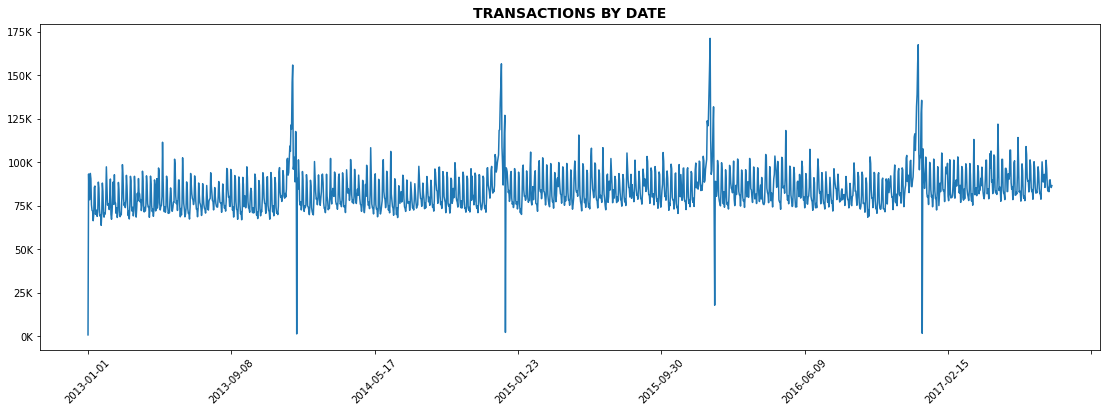

In [16]:
fig, ax = plt.subplots(figsize= (19,6))
transactions_date.dropna().plot(legend=None)
plt.xticks(rotation=45)
ax.set_title("TRANSACTIONS BY DATE", fontweight="bold", fontsize=14)
ax.set_xlabel(None)
ax.yaxis.set_major_formatter(values)
plt.show()

### **File:** train.csv and test.csv
<p style="text-align: justify">This file contains 4 (four) columns: id (In this case, it's irrelevant!), date, store_nbr, family, sales (target variable) and onpromotion. Here, I will make some observations that I think are important for us to think about the training set.</p>
<p style="text-align: justify"> The family variable has categorical values, in my opinion, which are relevant to be analyzed in separate columns can add value to the calculations. However, when we go to test our model in the test suite, this column will not be separated.</p>

<p style="text-align: justify">The influences of the promotion column on the family, store and data columns. Is there a strong relationship?
We could use Person Correlation to perform these evaluations. Personally, I prefer bar charts for better visualization. However, I will put an example of Person Correlation.</p>

<p style="text-align: justify">About store data (store.csv), we can merge with store data (train.csv). We can even create a column to list stores located in cities where events took place.</p>

Let's go?

In [17]:
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [18]:
# Merge train -  stores - transactions
df = pd.merge(train,stores,on='store_nbr')
df['date'] = pd.to_datetime(df['date'])
df.head()


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13


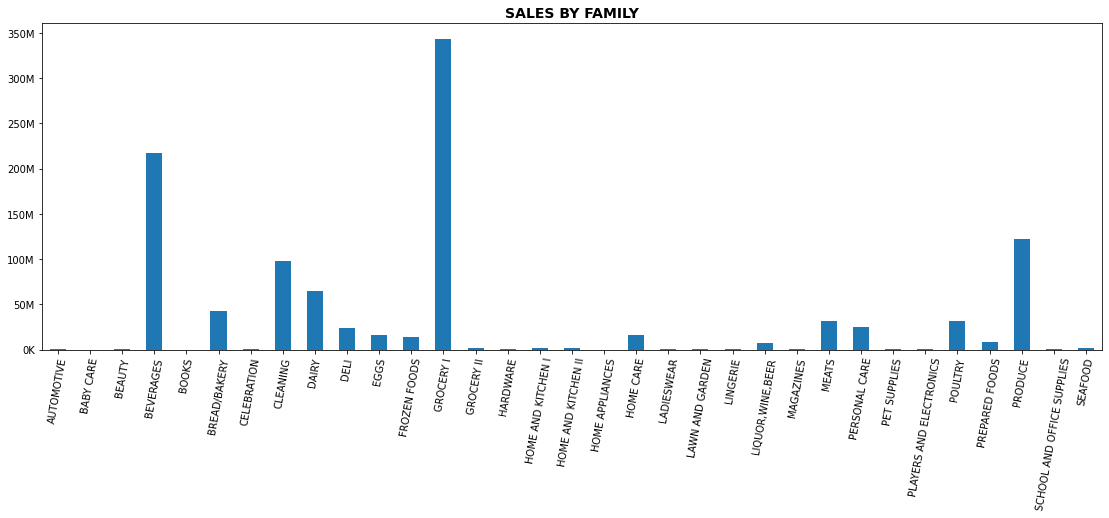

In [19]:
# SALES by FAMILY
fig, ax = plt.subplots(figsize= (19,6))
df.groupby('family')['sales'].sum().plot(kind='bar',legend=None)
plt.xticks(rotation=80)
ax.set_title("SALES BY FAMILY", fontweight="bold", fontsize=14)
ax.set_xlabel(None)
ax.yaxis.set_major_formatter(values)
plt.show()

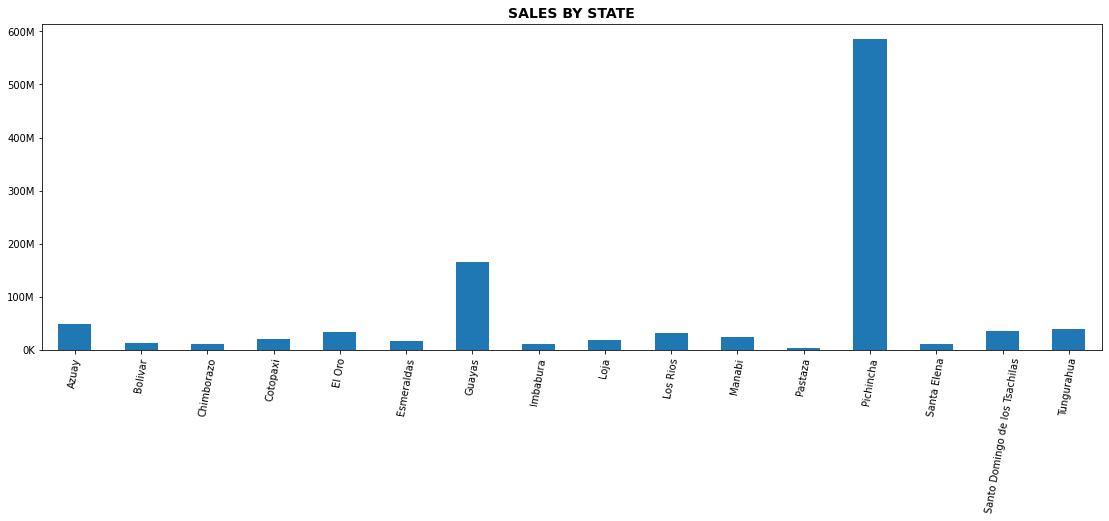

In [20]:
# SALES by STATE
fig, ax = plt.subplots(figsize= (19,6))
df.groupby('state')['sales'].sum().plot(kind='bar',legend=None)
plt.xticks(rotation=80)
ax.set_title("SALES BY STATE", fontweight="bold", fontsize=14)
ax.set_xlabel(None)
ax.yaxis.set_major_formatter(values)
plt.show()

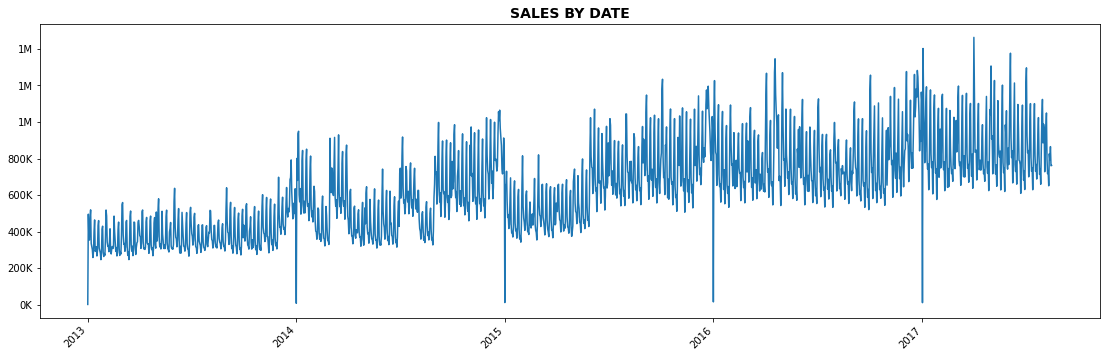

In [21]:
# SALES by DATE
fig, ax = plt.subplots(figsize= (19,6))
df.groupby('date')['sales'].sum().plot(legend=None)
plt.xticks(rotation=45)
ax.set_title("SALES BY DATE", fontweight="bold", fontsize=14)
ax.set_xlabel(None)
ax.yaxis.set_major_formatter(values)
plt.show()

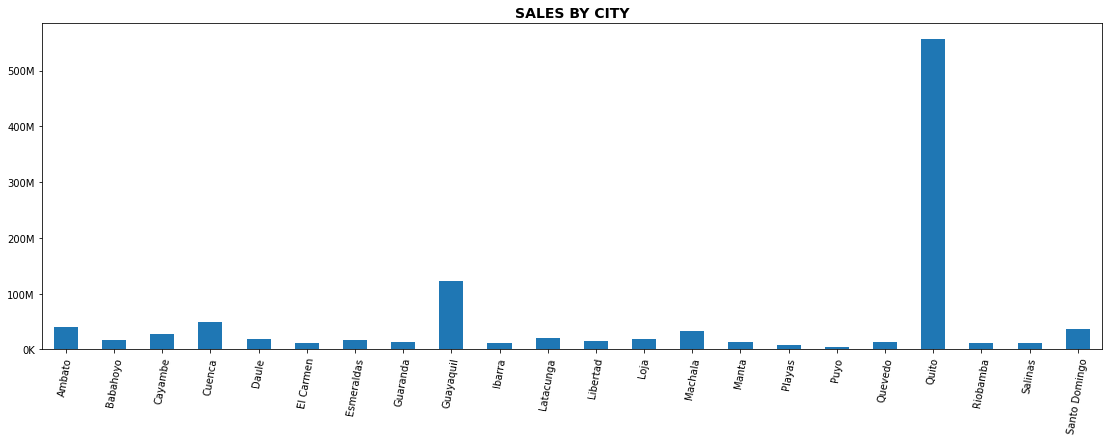

In [22]:
# SALES by CITY
fig, ax = plt.subplots(figsize= (19,6))
df.groupby('city')['sales'].sum().plot(kind='bar',legend=None)
plt.xticks(rotation=80)
ax.set_title("SALES BY CITY", fontweight="bold", fontsize=14)
ax.set_xlabel(None)
ax.yaxis.set_major_formatter(values)
plt.show()

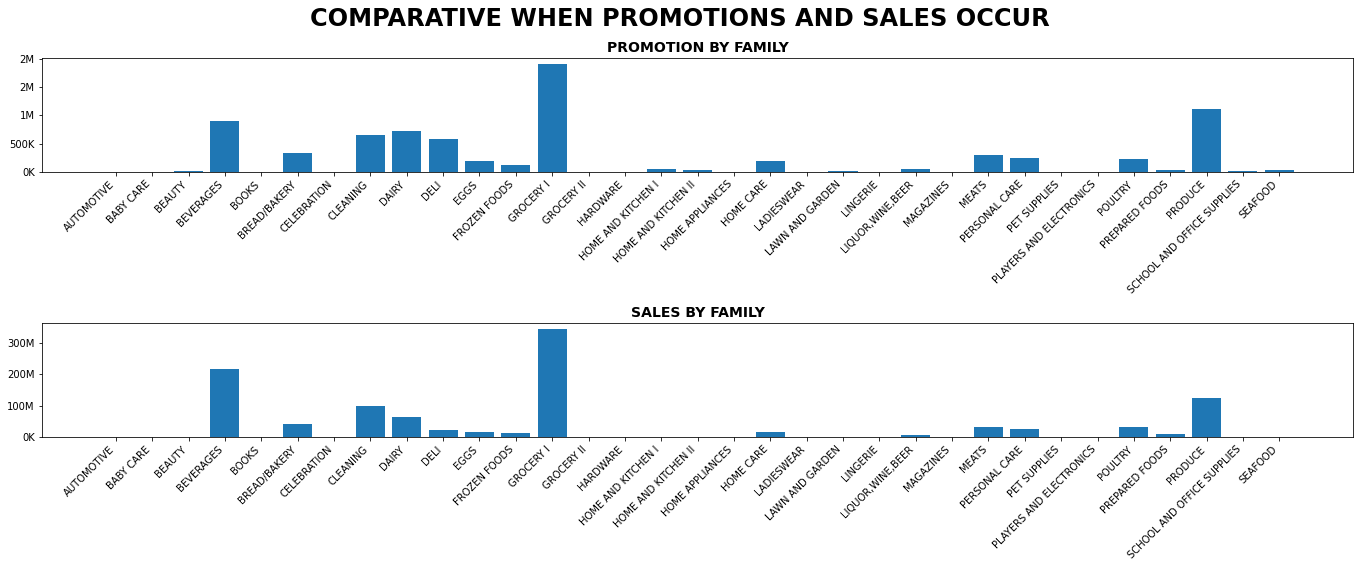

In [23]:
# PROMOTION by FAMILY

fig, ax = plt.subplots(2,1,figsize= (19,8))
plt.suptitle("COMPARATIVE WHEN PROMOTIONS AND SALES OCCUR", fontweight="bold", fontsize=24)
ax[0].bar(df.groupby('family')['onpromotion'].sum().index,df.groupby('family')['onpromotion'].sum().values)
labels = ax[0].get_xticklabels()
plt.setp(labels, rotation=45, horizontalalignment='right')
ax[0].set_title("PROMOTION BY FAMILY", fontweight="bold", fontsize=14)
ax[0].set_xlabel(None)
ax[0].yaxis.set_major_formatter(values)

ax[1].bar(df.groupby('family')['sales'].sum().index,df.groupby('family')['sales'].sum().values)
labels = ax[1].get_xticklabels()
plt.setp(labels, rotation=45, horizontalalignment='right')
ax[1].set_title("SALES BY FAMILY", fontweight="bold", fontsize=14)
ax[1].set_xlabel(None)
ax[1].yaxis.set_major_formatter(values)

fig.tight_layout()

plt.show()

### 2nd Part: **Analysing the Time Series**


In [24]:
# Create a DataSet to work with Time Series
df = train
df['date'] = pd.to_datetime(df['date'])

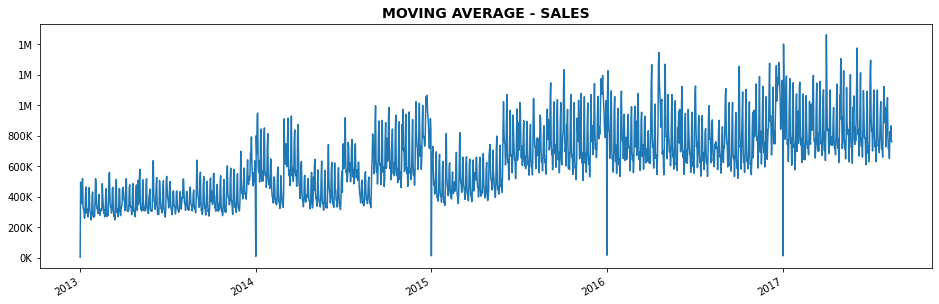

In [25]:
## Moving Average
fig, ax = plt.subplots(figsize= (16,5))
df.groupby('date')['sales'].sum().plot()
ax.set_title("MOVING AVERAGE - SALES", fontweight="bold", fontsize=14)
ax.set_xlabel(None)
ax.yaxis.set_major_formatter(values)
plt.show()

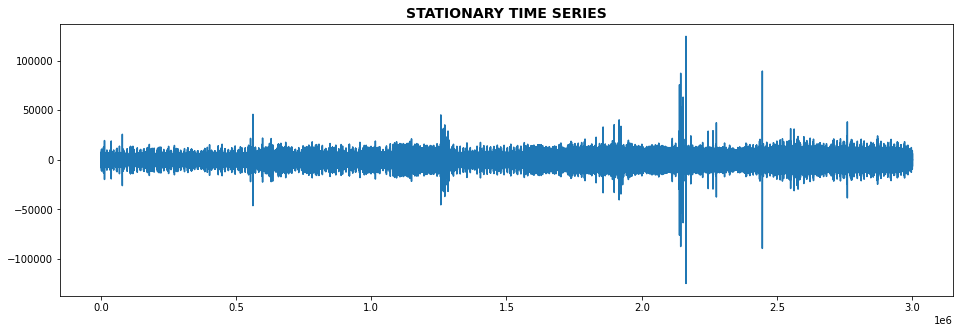

In [26]:
fig, ax = plt.subplots(figsize= (16,5))
df.sales.diff(1).plot()
ax.set_title("Stationary Time Series".upper(), fontweight="bold", fontsize=14)
ax.set_xlabel(None)
plt.show()

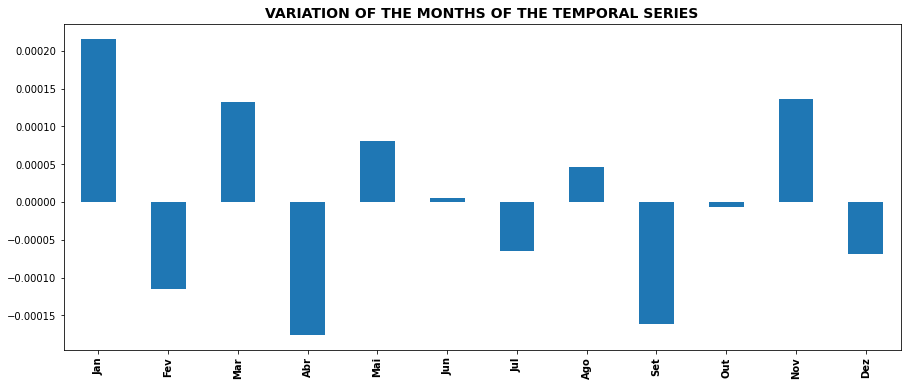

In [27]:
# Variância nos Meses da Série Histórica
df.sales.diff(1).groupby(df.date.dt.month).mean().plot(kind='bar', figsize=(15, 6))
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11],['Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez'], fontweight='bold')
plt.title("Variation of the months of the Temporal series".upper(),  fontweight="bold", fontsize=14)
plt.xlabel(None)
plt.show()

<div style="text-align: justify"> Analyzing the chart above, JANUARY has the biggest drops in terms of the sales. In DECEMBER, Sales are on the rise. Over the months we noticed there are few variations between highs and lows.</div>

### 3rd Part: **Preparation**

In [28]:
# Make lists with categorical and numerical variables:
cat_cols = [c for c in df.columns if df[c].dtypes=='O']
num_cols = [c for c in df.columns if df[c].dtypes!='O']

from feature_engine.encoding import OneHotEncoder
encoder = OneHotEncoder()
X_cat_encod = encoder.fit_transform(df[cat_cols])
X_num_col = df.drop(labels=cat_cols, axis=1)

# New DataFrame 
df_encod = pd.concat([X_num_col,X_cat_encod], axis=1)
df = df_encod.set_index(['date'])

In [29]:
# Separating Features and Target
X = df.drop(labels=['sales'], axis=1)
y = df['sales']

In [30]:
# Total Lines
lines = df.shape[0]
print(f'DataFrame has {lines:1,d} lines.')

# Train - Test values
train_values = int(lines * 0.7)

X_train = X[:train_values]
y_train = X[train_values:]

X_test = y[:train_values]
y_test = y[train_values:]

DataFrame has 3,000,888 lines.


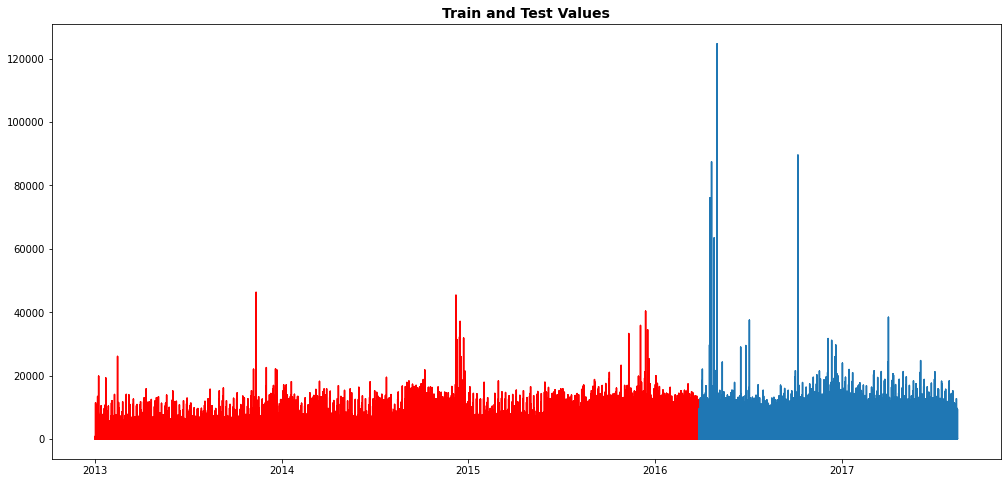

In [31]:
# Plotting Train and Test Values
plt.figure(figsize=(17,8))
plt.plot(X_train.index,X_test,c='red')
plt.plot(y_train.index,y_test)
plt.title("Train and Test Values", fontweight="bold", fontsize=14)
plt.show()

#### **Naive Method**

<div style="text-align: justify">The Naive Method is very simple. This approach starts from the simple principle that events in the near future will be similar on recents events. In this regard, we need to adjust the sales columns to day ahead.</p>

In [32]:
# Creating a Column - Naive_Prediction
df_naive = df.copy()
df_naive['naive_prediction'] = df.sales.shift(1)
df_naive = df_naive[['sales', 'naive_prediction']]
df_naive.dropna(inplace=True)

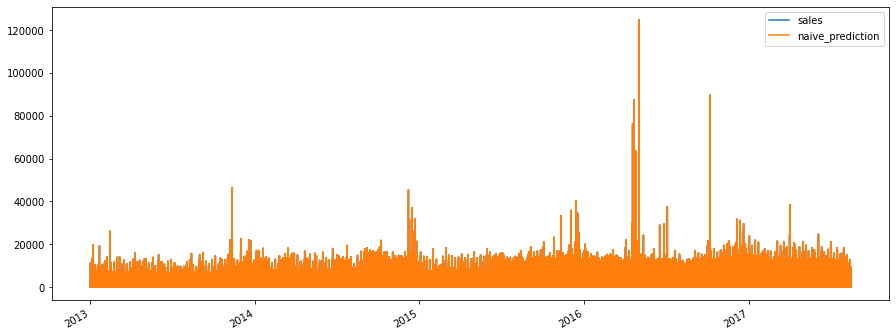

In [33]:
# Plot this Model
df_naive.plot(figsize=(15,6))
plt.xlabel("")
plt.show()

Let's see how was Metric Score Error (MSE)!

In [34]:
mse_naive = mean_squared_error(df_naive['sales'],df_naive['naive_prediction'])
print(f'The Metric Score Error (Naive): {mse_naive:1,f}')

The Metric Score Error (Naive): 2,487,500.730759


This model is used as a parameter for other models. 

#### **Autoregressive Model**
<div style="text-align: justify">The Autoregressive model uses a linear regression to reach the expected values.</p>


In [35]:
df_AR = df_naive.copy()
df_AR.rename(columns={'naive_prediction':'x1'},inplace=True)
df_AR.head()


,sales,x1
date,,
2013-01-01,0.0,0.0
2013-01-01,0.0,0.0
2013-01-01,0.0,0.0
2013-01-01,0.0,0.0
2013-01-01,0.0,0.0


In [36]:
from sklearn.linear_model import LinearRegression
X = np.array(df_AR['x1']).reshape(-1,1)
y = np.array(df_AR['sales'])

# Linear Regression Model

lr = LinearRegression()       # Create Model
lr.fit(X, y)                  # Adjusting Model
predictions = lr.predict(X)   # Predict Values

mse_ar = mean_squared_error(y, predictions)
print(f'The Metric Score Error (Autoregressive): {mse_ar:1,f}')

The Metric Score Error (Autoregressive): 1,213,689.525513


In [37]:
df_AR['AUTOR_1'] = predictions
df_AR

,sales,x1,AUTOR_1
date,,,
2013-01-01,0.000,0.000,366.423136
2013-01-01,0.000,0.000,366.423136
2013-01-01,0.000,0.000,366.423136
2013-01-01,0.000,0.000,366.423136
2013-01-01,0.000,0.000,366.423136
...,...,...,...
2017-08-15,438.133,6.000,366.278119
2017-08-15,154.553,438.133,355.833676
2017-08-15,2419.729,154.553,362.687666


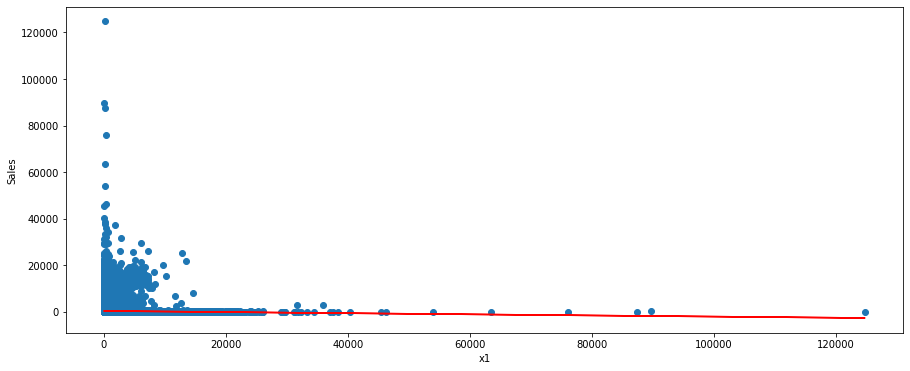

In [38]:
# Plotting Autoregressive Model
plt.figure(figsize=(15,6))
plt.scatter(X,y)
plt.plot(X, lr.predict(X.reshape(-1, 1)), color='red')
plt.xlabel('x1')
plt.ylabel('Sales')
plt.show()

We had a better performance compared to the Naive Model, but we still need to improve a lot!
Maybe it is, because we have a lot of zeros in the sales column. Let's remove these values ​​and see if it improves performance!

In [39]:
df_AR_0 = df_AR.copy()
df_AR_0 = df_AR_0[df_AR_0['sales']>0]
df_AR_0.drop(columns=['x1', 'AUTOR_1'], inplace=True)
df_AR_0['x1_0'] = df_AR_0.sales.shift(1)
df_AR_0.dropna(axis=0, inplace=True)

X0 = np.array(df_AR_0['x1_0']).reshape(-1,1)
y0 = np.array(df_AR_0['sales'])

# Linear Regression Model

lr_AR_0 = LinearRegression()       # Create Model
lr_AR_0.fit(X0, y0)                  # Adjusting Model
predictions_0 = lr_AR_0.predict(X0)   # Predict Values



mse_naive_AR_0 = mean_squared_error(df_AR_0['sales'],df_AR_0['x1_0'])
print(f'The Metric Score Error - Naive Model without Zeros:     {mse_naive_AR_0:1,f}') # It's worse!!!!!

mse_ar_0 = mean_squared_error(y0, predictions_0)
print(f'The Metric Score Error - Auto Regressive without Zeros: {mse_ar_0:1,f}')


The Metric Score Error - Naive Model without Zeros:     3,450,353.965895
The Metric Score Error - Auto Regressive without Zeros: 1,681,621.078476


In [40]:
df_AR_0['AutoR_without_zeros'] = predictions_0
df_AR_0.head()

,sales,x1_0,AutoR_without_zeros
date,,,
2013-01-01,810.000,2.000,533.839526
2013-01-01,180.589,810.000,513.439782
2013-01-01,186.000,180.589,529.330652
2013-01-01,143.000,186.000,529.194040
2013-01-01,71.090,143.000,530.279670


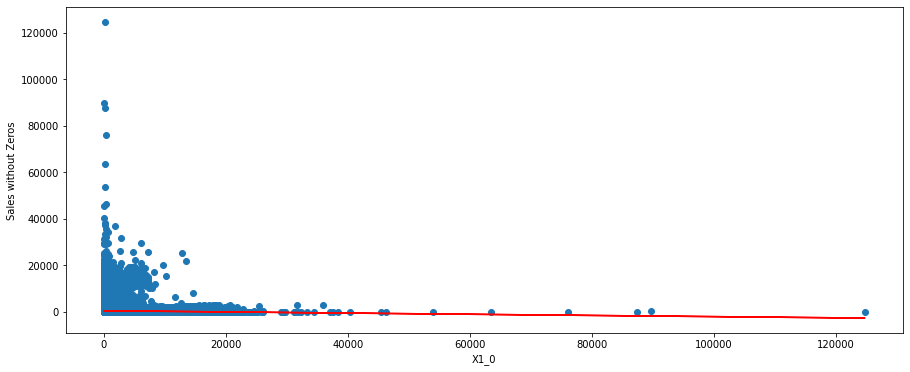

In [41]:
# Plotting Autoregressive Model Without zeros
plt.figure(figsize=(15,6))
plt.scatter(X0,y0)
plt.plot(X0, predictions_0, color='red')
plt.xlabel('X1_0')
plt.ylabel('Sales without Zeros')
plt.show()

Humm!! The Model was worse than the previous one. Removing the zeros wasn't a good solution.

Let's use the same model (Autoregression) with 2 (two) lags.

In [42]:
df_AR['x2'] = df_AR.sales.shift(2)
df_AR.dropna(axis=0, inplace=True)

# Create Model Autoregression with 2 lags
X2 = df_AR[['x1', 'x2']]
y2 = df_AR.sales.values

# Linear Regression Model 2 lags

lr2 = LinearRegression()       # Create Model
lr2.fit(X2, y2)                  # Adjusting Model
predictions2 = lr2.predict(X2)   # Predict Values

mse_ar2 = mean_squared_error(y2, predictions2)
print(f'The Metric Score Error - AR 2 Lags: {mse_ar2:1,f}')

The Metric Score Error - AR 2 Lags: 1,213,050.621368


In [43]:
df_AR['AUTOR_2'] = predictions2
df_AR.head()

,sales,x1,AUTOR_1,x2,AUTOR_2
date,,,,,
2013-01-01,0.0,0.0,366.423136,0.0,362.140688
2013-01-01,0.0,0.0,366.423136,0.0,362.140688
2013-01-01,0.0,0.0,366.423136,0.0,362.140688
2013-01-01,0.0,0.0,366.423136,0.0,362.140688
2013-01-01,0.0,0.0,366.423136,0.0,362.140688


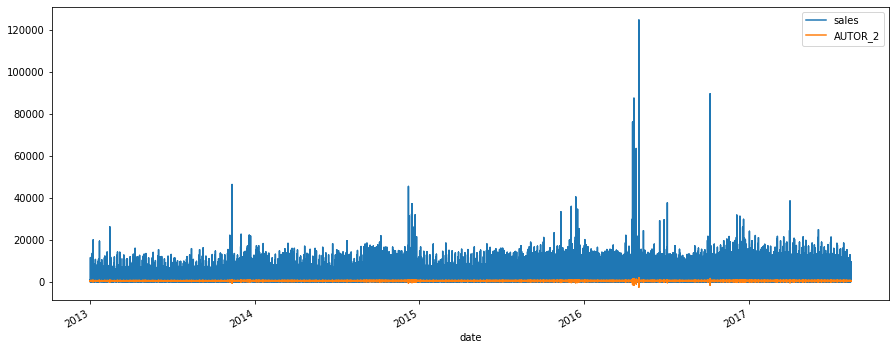

In [44]:
df_AR[['sales', 'AUTOR_2']].plot(figsize=(15,6)) # Terrible!!!!
plt.show()

Let's try to use `from statsmodels.tsa.ar_model import AR` with ***2 lags***.

In [45]:
from statsmodels.tsa.ar_model import AutoReg
ar_2 = AutoReg(df_AR['sales'], lags=2).fit()

C:\Users\willi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [46]:
mse_ar2 = mean_squared_error(df_AR['sales'][2:], ar_2.resid)
print(f'The Metric Score Error - AR with 2 (two) lags:        {mse_ar2:1,f}')

print(f'The Metric Score Error - AR with 1 (one) lag:       {mse_ar:1,f}')

The Metric Score Error - AR with 2 (two) lags:        129,662.903244
The Metric Score Error - AR with 1 (one) lag:       1,213,689.525513


In [47]:
# Plotting Autoregressive StatsModels AR
df_AR = df_AR[2:]
df_AR['AUTOR_2_sts'] = ar_2.resid
df_AR

C:\Users\willi\AppData\Local\Temp/ipykernel_620/2116274608.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_AR['AUTOR_2_sts'] = ar_2.resid


,sales,x1,AUTOR_1,x2,AUTOR_2,AUTOR_2_sts
date,,,,,,
2013-01-01,0.000,0.000,366.423136,0.000,362.140688,-356.174401
2013-01-01,0.000,0.000,366.423136,0.000,362.140688,-356.174401
2013-01-01,0.000,0.000,366.423136,0.000,362.140688,-356.174401
2013-01-01,0.000,0.000,366.423136,0.000,362.140688,-356.174401
2013-01-01,0.000,0.000,366.423136,0.000,362.140688,-356.174401
...,...,...,...,...,...,...
2017-08-15,438.133,6.000,366.278119,6.000,362.067492,81.931734
2017-08-15,154.553,438.133,355.833676,6.000,351.612967,-191.495905
2017-08-15,2419.729,154.553,362.687666,438.133,363.656424,2054.930540


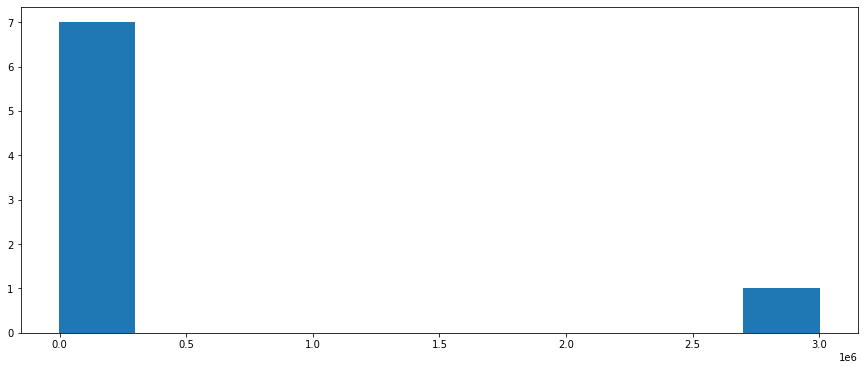

In [48]:
# Plot Histogram
ar_2.resid.describe().hist(figsize=(15,6))
plt.grid(None)

In [52]:
ar_2.params

const       356.174401
sales.L1     -0.023494
sales.L2      0.027971
dtype: float64

In [53]:
previsoes = ar_2.params[0]
for i, param in enumerate(ar_2.params[1:]):
    previsoes += test.shift(i + 1) * param
previsoes

TypeError: can't multiply sequence by non-int of type 'float'

In [ ]:
"""from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_AR['sales'])
plt.show()"""

In [ ]:
"""plot_pacf(df.Sales, lags=10)
plt.show()"""